# Vehicle license plate detection and recognition 

### Step1: License plate detection  

Vehicle License plate detection and recognition is a well-known challenge that has been tackled by many computer-vision labs and companies. But each country has its own lisence plate format in this case I tried to make a custom model for Tunisian lisence plate. 

- Detection: we use yolov3 from darknet in order to train a custom license plate detection model.
- Recognition: we use optical character recognition to extract information

Detection steps: 
- we downloaded a labeled data from [Google Image Data](https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F0k5j).
- we install darknet (the most difficult part when using windows operating system it is very easy with linux). this [tutorial](https://www.youtube.com/watch?v=saDipJR14Lc) is very helpful. 
- we train our custom model.

#### Convergence 

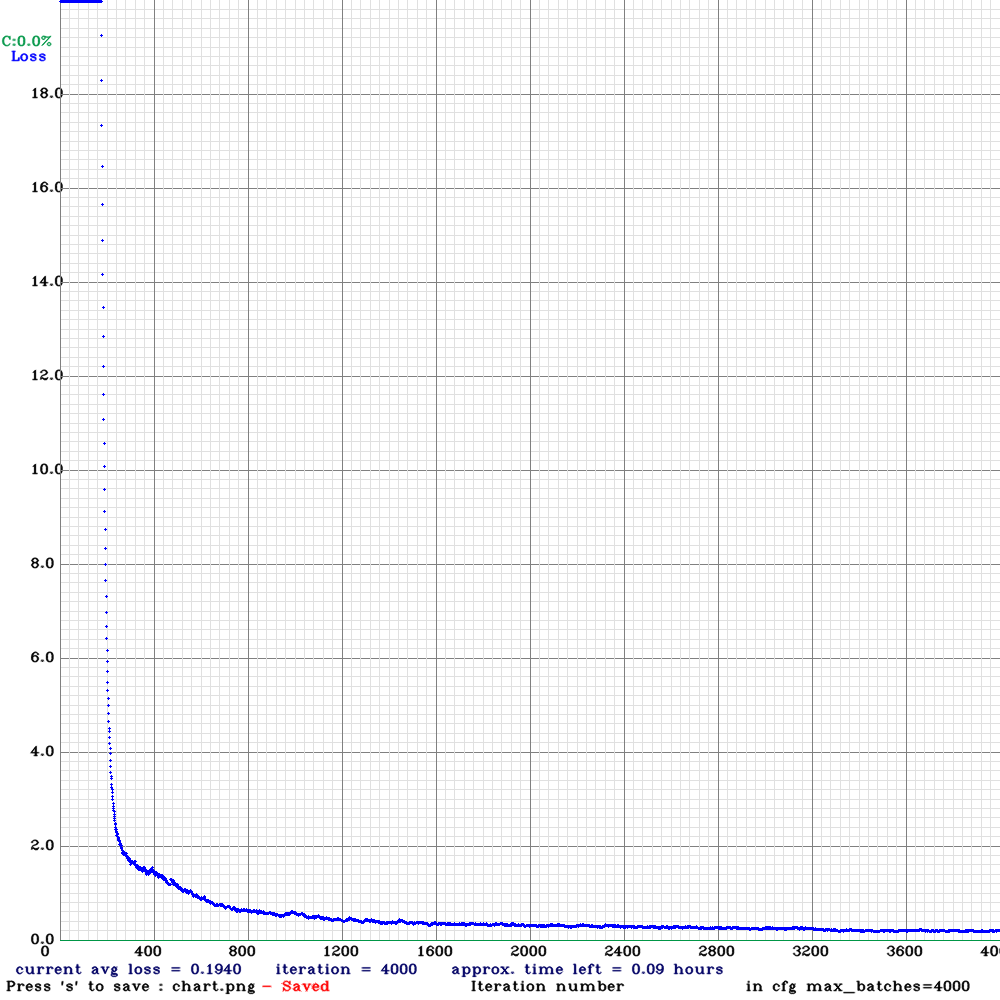

In [1]:
from IPython.display import Image
Image(filename='chart_yolov3-custom.png') 

In [19]:
import cv2
import re
import time
import numpy as np
from PIL import Image 
import pytesseract

In [3]:
LABELS = open('names\obj.names').read().strip().split("\n")
CFG = 'cfg\yolov3-custom.cfg'
WEIGHTS = 'trained_weights\yolov3-custom_last.weights'

In [4]:
print("In our case we have only one label which is the license plate: " + str(len(LABELS)))

In our case we have only one label which is the license plate: 1


In [5]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [6]:
def Detection(image_path, cfg=CFG, weights=WEIGHTS, labels=LABELS):
    ### Reading our image 
    image = cv2.imread(image_path)
    (H, W) = image.shape[:2]

    
    ### Reading our parameters
    net = cv2.dnn.readNetFromDarknet(cfg, weights)
    
    ### Different layers in yolov3 architecture (conv_0', 'bn_0', 'relu_1' ...)
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)

    ### Detection Time
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    print('-'*40)
    print("YOLO took {:.6f} seconds to detect our targets objects".format(end - start))
    print('-'*40)
    
    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.3:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)
    if len(idxs) > 0:
        for i in idxs.flatten():

            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,127,0), 2)

    cv2.imshow("You Only Look Once", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return boxes, image

In [7]:
import os 

In [8]:
Bx = []


DIRS = os.listdir(os.getcwd())
path = 'images'
for DIR in DIRS:
    if DIR == path:  
        if os.path.isdir(DIR):
            os.chdir(DIR)
            print("Currently in subdirectory:", DIR)
            filenames = os.listdir(os.getcwd())
            print(filenames)
os.chdir('..')

Currently in subdirectory: images
['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg']


In [10]:
for filename in filenames:
    path = "images/"  + filename
    temp, image = Detection(path, cfg=CFG, weights=WEIGHTS, labels=LABELS)
    cv2.imwrite(str(filename[:-4])+str('pred.jpg'), image)
    Bx.append(temp)

----------------------------------------
YOLO took 0.580664 seconds to detect our targets objects
----------------------------------------
----------------------------------------
YOLO took 0.507694 seconds to detect our targets objects
----------------------------------------
----------------------------------------
YOLO took 0.537676 seconds to detect our targets objects
----------------------------------------
----------------------------------------
YOLO took 0.509693 seconds to detect our targets objects
----------------------------------------


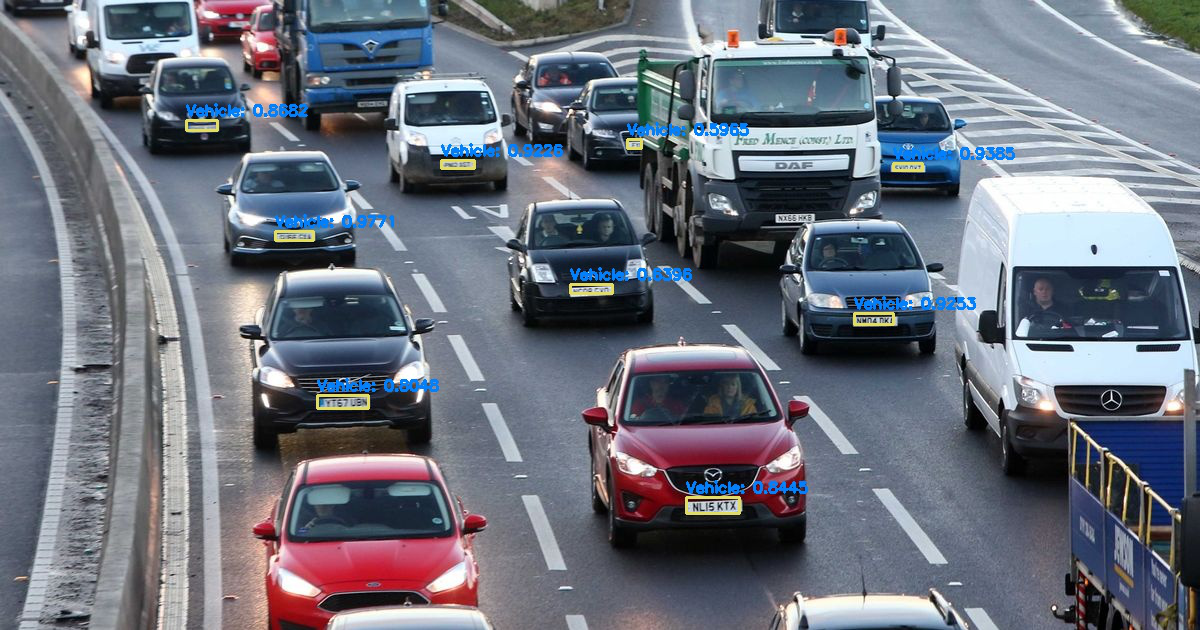

In [17]:
Image.open('image1pred.jpg')

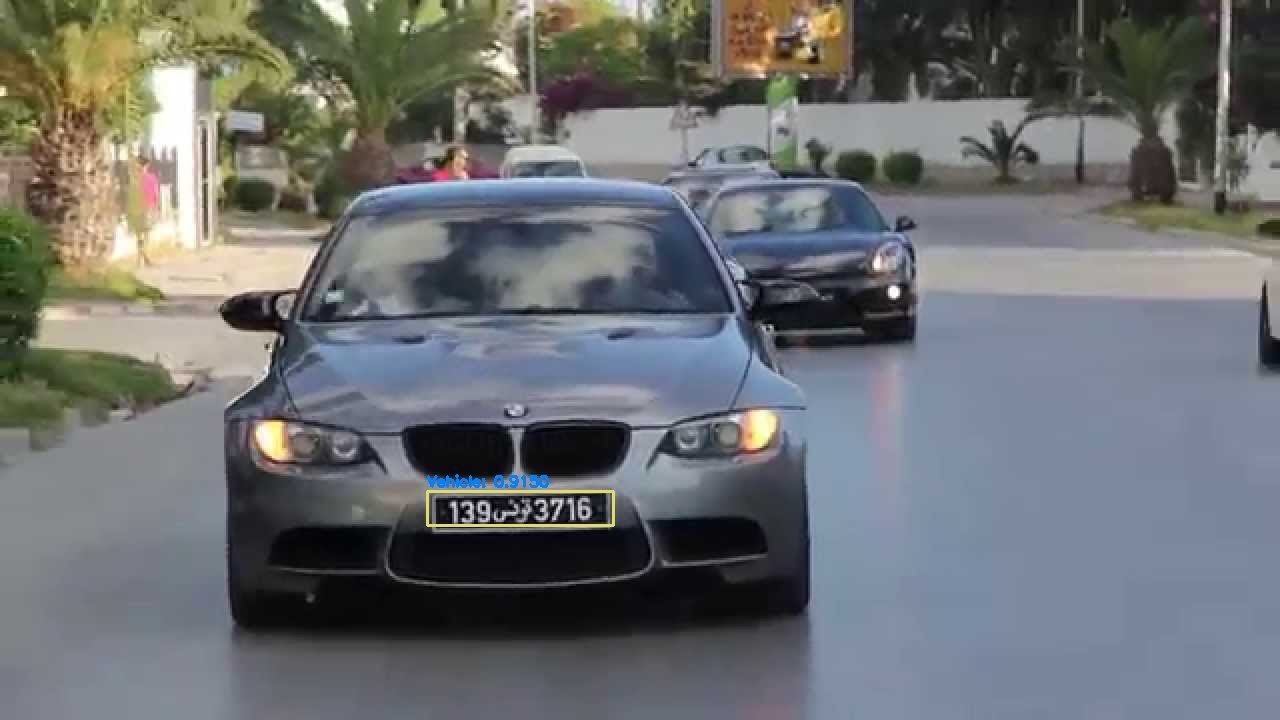

In [18]:
Image.open('image2pred.jpg')

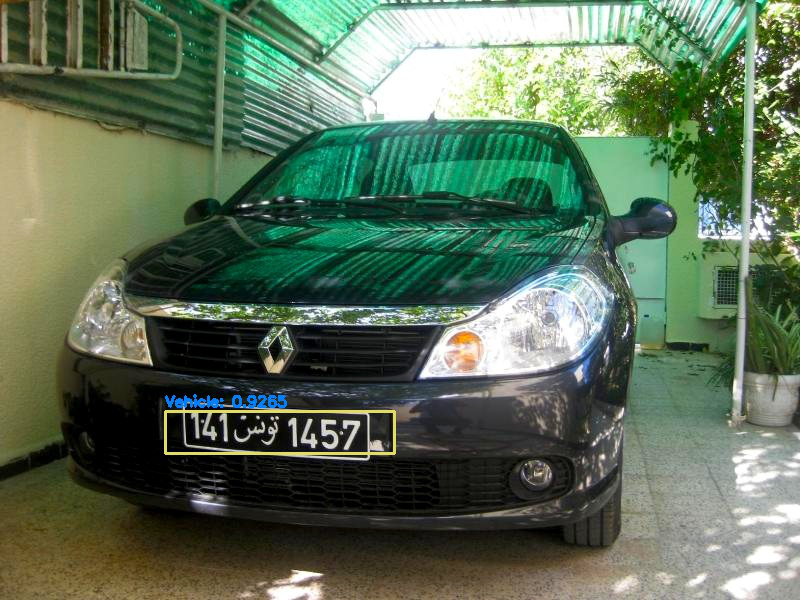

In [47]:
Image.open('image3pred.jpg')

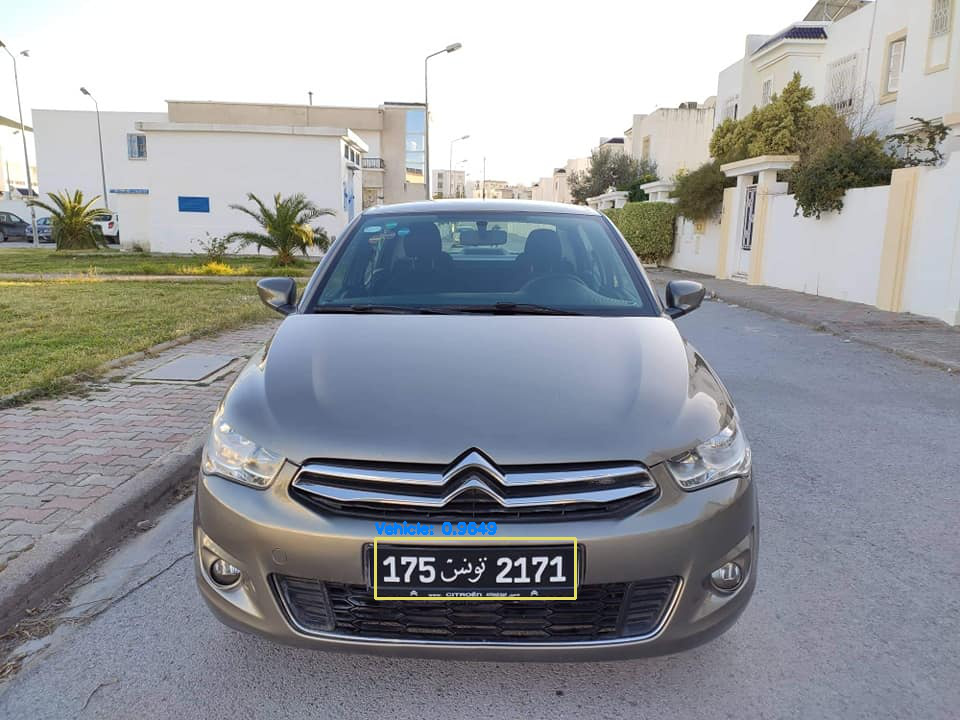

In [11]:
Image.open('image4pred.jpg')

### Step2: License plate recognition  

we wil use tesseract engine to extract numbers from the license plate. 

we can also using a digit recognition model and a sliding window technique to extract each digit. 

In [12]:
Bx[3]

[[375, 538, 200, 60], [384, 543, 193, 52]]

In [13]:
gray = cv2.imread('images/image4.jpg',0)
cv2.imshow('car', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [15]:
x, y, w, h = Bx[3][1]
crop_img = gray[y:y+h, x:x+w]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
#th = cv2.threshold(crop_img,127,255,cv2.THRESH_BINARY_INV)[1]
th = cv2.threshold(cv2.GaussianBlur(crop_img,(3,3),0),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
cv2.imshow('img',th)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
re.sub('[^0-9]',' ',pytesseract.image_to_string(th, lang='eng', config='--psm 10')).strip()

'175    2171'